<font size="8"> **Mixed layer depth in the Southern Ocean** </font>  
  
In this notebook, we investigate the Mixed Layer Depth within the Southern Ocean as estimated by ACCESS-OM2-01. We also compare model outputs to observations from [Sallee and collaborators](https://zenodo.org/record/5776180).

# Setting working directory
In order to ensure these notebooks work correctly, we will set the working directory. We assume that you have saved a copy of this repository in your home directory (represented by `~` in the code chunk below). If you have saved this repository elsewhere in your machine, you need to ensure you update this line with the correct filepath where you saved these notebooks.

In [1]:
import os
#Ensure you update this filepath if you have saved these notebooks elsewhere in your machine
os.chdir(os.path.expanduser('~/ACCESS-OM2-01_EcologicallyRelevantVariables/Scripts'))

You can print your working directory using the chunk below to make sure you are in the correct folder containing these notebooks.

In [ ]:
!pwd

# Loading relevant libraries
Note that the `ZonalStatsFuncions` refers to a `Python` script that contains functions that were commonly used throughout this work. These libraries are mostly used to access and manipulate data.

In [2]:
import cosima_cookbook as cc
import xarray as xr
import numpy as np
import pandas as pd
from dask.distributed import Client
from glob import glob
#Importing script containing functions developed to calculate timeseries
import ZonalStatsFunctions as zsf
import datetime as dt
import xesmf as xe
from scipy.io import loadmat
from itertools import cycle
import string

The following modules are used in plotting maps and time series.

In [3]:
#Packages for plotting
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as mcm
import cmocean as cm           
import cartopy.crs as ccrs
import cartopy.feature as cft
import matplotlib.gridspec as gridspec
import geopandas

#This first line will show plots produced by matplotlib inside this Jupyter notebook
%matplotlib inline

# Accessing ACCESS-OM2-01 outputs
We will start a cluster that has multiple cores to work with and make analyses faster. Remember that the number of cores cannot exceed the number of CPUs requested when accessing GADI.  
  
If the line below does not run, you can skip it. The result is that the job will not be parallelised, but the script will still run.

In [6]:
client = Client()

We will now need to a new start in the COSIMA cookbook, which will give us access to the default ACCESS-OM2 experiment database from where we will load the data of our interest.

In [22]:
session = cc.database.create_session()

This notebook uses outputs for the second cycle, v140 run of ACCESS-OM2-01, which includes atmospheric forcing (`01deg_jra55v140_iaf_cycle2`). To see a list of all ACCESS-OM2-01 experiments you can use the `cc.querying.get_experiments(session)` from the COSIMA cookbook. A detailed list of experiments can be obtained by adding the following argument: `all = True`.  
  
For more detail instructions on how to use the COSIMA Cookbook check their [tutorial](https://github.com/COSIMA/cosima-recipes/blob/master/Tutorials/COSIMA_CookBook_Tutorial.ipynb).

## Set up dictionary of variables prior accessing ACCESS-OM2 model outputs
The dictionary below contains a list of variables containing information that will be used multiple times throughout this notebook. Largely these are file paths to folders where data is either stored or saved. Ensure you update these variables based on your needs.

In [7]:
varDict =  {'var_id': 'mld',
            'model': 'ACCESS-OM2-01',
            'expt': '01deg_jra55v140_iaf_cycle2', # ACCESS-OM2-01 cycle 2
            'freq': '1 monthly',
            'start_date': range(1965, 2018, 1),
            'long_name': 'mixed layer depth',
            'short_name': 'MLD',
            'unit': 'm',
            'CICE_data': False, #This is not sea ice related data
            'base_data': r'/g/data/v45/la6889/Calculations/MLD/Data',
            'climatologies': r'/g/data/v45/la6889/Calculations/MLD/Climatologies',
            'clim_fig': r'/g/data/v45/la6889/Figures/MLD/Climatologies',
            'linear_trends': r'/g/data/v45/la6889/Calculations/MLD/LinearTrends',
            'std_err': r'/g/data/v45/la6889/Calculations/MLD/Std_Errors',
            'lm_fig': r'/g/data/v45/la6889/Figures/MLD/LinearTrends',
            'clipped_data': r'/g/data/v45/la6889/Calculations/MLD/ClippedMEASOregions/',
            'decades': range(1965, 2019, 10),
            'res': '0.1°'}

# Loading and saving ACCESS-OM2 outputs for MLD in the Southern Ocean
We will use the COSIMA Cookbook to search and load the MLD data we need, we will then extract data for the Southern Ocean only, correct the longitude values, and finally save it to our disk to avoid having to apply this step every time we need access to this data.

In [33]:
#Getting directory where our corrected data will be saved
dir_out = varDict['base_data']
#If directory does not exist, create one
os.makedirs(dir_out, exist_ok = True)

#Looping through decades of interest. This makes it easier to access and manipulate data.
for yr in varDict['decades']:
    #Accessing data per decade
    stime = f'{str(yr)}-01'
    etime = f'{str(yr+9)}-12'
    #Accessing ACCESS 0.1deg outputs for the entire time range of interest
    SO = zsf.getACCESSdata(varDict['var_id'], stime, etime, freq = varDict['freq'], ses = session, 
                           minlat = -80, maxlat = -35, ice_data = varDict['CICE_data'])
        
    #Correcting longitudes
    SO = zsf.corrlong(SO)
    #Saving data within the decade of interest only
    SO = SO.sel(time = slice(stime, etime))
    #Creating name of file    
    fn = f'MixedLayerDepth_{str(yr)}-{str(yr+9)}.nc'
    #Saving file
    SO.to_netcdf(os.path.join(dir_out, fn))

## Loading longitude corrected MLD data for the SO saved in the previous step
To avoid subsetting and correcting MLD data every time this notebook is run, simply run the chunk below.

In [ ]:
#Concantenating all files into a single data array
SO = xr.open_mfdataset(os.path.join(varDict['base_data'], '*.nc')).mld
SO

# Loading MEASO regions shapefile
We will load this shapefile to overlay it on all maps created in this notebook.

<AxesSubplot:>

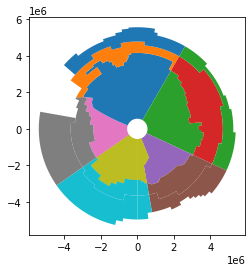

In [6]:
#Load shapefile
MEASO = geopandas.read_file('../SupportingData/MEASO/measo.shp')

#Remove temperate zones as they are not within area of interest
MEASO = MEASO.query('zone != "Temperate"')

#Add a column with the long name for each MEASO area
MEASO = MEASO.assign(long_name = (MEASO.sector + ' ' + MEASO.zone).to_list())

#Checking results
MEASO.plot(column = 'long_name')

# Mixed layer depth derived from observations
Observations were obtained from [Sallee et al 2021](https://doi.org/10.1038/s41586-021-03303-x), which include data for mixed layer depth between 1970 and 2018. Version 2 of this dataset was downloaded from their [Zenodo repository](https://zenodo.org/record/5776180#.YcJf8NBBw2w). The second version of this dataset provide a more robust calculation of the monthly climatologies according to the release notes (see the note under `Readme` in the climatology dataset for more information).  
  
The observational dataset has been stored in a folder called `Observations` in the root directory of this repository.

## Loading global monthly climatological means
Note that the data structure is loaded as a dictionary in Python. All variables related to climatology are included under the `MLCLimato` key of this dictionary.

In [63]:
#Loading the MATLAB data structure containing the climatological data to the notebook
obs = loadmat('../Observations/GlobalML_Climato_1970_2018.mat')

In [9]:
obs['MLClimato'].dtype

dtype([('lon', 'O'), ('lat', 'O'), ('ML_temp', 'O'), ('ML_depth', 'O'), ('ML_psal', 'O'), ('ML_temp_BaseMLstratif', 'O'), ('ML_sal_BaseMLstratif', 'O'), ('ML_sal_0_200stratif', 'O'), ('ML_temp_0_200stratif', 'O'), ('ML_temp_stderror', 'O'), ('ML_depth_stderror', 'O'), ('ML_psal_stderror', 'O'), ('ML_temp_BaseMLstratif_stderror', 'O'), ('ML_sal_BaseMLstratif_stderror', 'O'), ('ML_sal_0_200stratif_stderror', 'O'), ('ML_temp_0_200stratif_stderror', 'O'), ('medianyear', 'O'), ('nbobs', 'O'), ('Readme', 'O')])

### Extracting latitude and longitude values
The `MATLAB data structure` appears as data frame nested inside two data frames when loaded using the `loadmat` function from `SciPy`.

In [64]:
lon = obs['MLClimato']['lon'][0][0][:,0]
lat = obs['MLClimato']['lat'][0][0][:,0]

### Loading monthly climatological means
Monthly climatological means are included under the `ML_depth` variable and as with the coordinates, it is nested within two data frames. A data array is constructed using the climatological means and the previously extracted coordinates before carrying out any analyses.

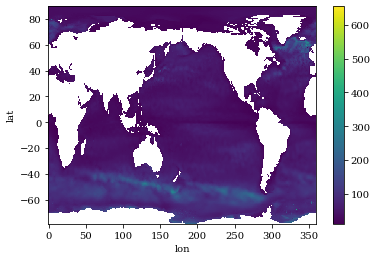

In [65]:
clim_means_obs = xr.DataArray(data = obs['MLClimato']['ML_depth'][0][0], 
                              dims = ['time', 'lat', 'lon'],
                              coords = {'lat': lat, 'lon': lon, 
                                        #Each time step represents a month
                                        'time': range(1, 13)})
#Check resulting data array
clim_means_obs.mean('time').plot()

## Loading seasonal linear trends
The trends file from Sallee et al (`GlobalML_Trend_1970_2018.mat`) contains the monthly trends (`ML_depth_trend` variable), and the standard errors (`ML_depth_stderror` variable) of the monthly linear trend. In the Sallee et al, trends were considered to be significant if the absolute trend values were larger than the standard error.

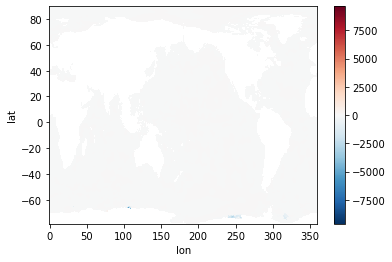

In [12]:
#Loading MATLAB data structure
obs_trends = loadmat('../Observations/GlobalML_Trend_1970_2018.mat')

#Creating data array with the monthly trends data 
month_trend_obs = xr.DataArray(data = obs_trends['MLtrend']['ML_depth_trend'][0][0],
                               dims = ['time', 'lat', 'lon'],
                               coords = {'lat': lat, 'lon': lon, 
                                         #Monthly data
                                         'time': range(1, 13)})
month_trend_obs.mean('time').plot()

### Loading standard error of linear trends

In [13]:
month_se_obs = xr.DataArray(data = obs_trends['MLtrend']['ML_depth_stderror'][0][0],
                            dims = ['time', 'lat', 'lon'],
                            coords = {'lat': lat, 'lon': lon, 
                                      #Montly data
                                      'time': range(1, 13)})

# Comparing seasonal climatological means in MLD (observations vs model)
Note that the model data will be regridded to match the observations before comparisons are performed.

## Calculating monthly climatology from model outputs
This step is done to match the observational data, which includes monthly climatologies.

In [43]:
climdata = SO.sel(time = slice('1970-01', '2018-12')).groupby('time.month').mean('time').rename({'month': 'time'})
climdata

<xarray.DataArray 'mld' (time: 12, yt_ocean: 844, xt_ocean: 3600)>
dask.array<stack, shape=(12, 844, 3600), dtype=float32, chunksize=(1, 844, 3600), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -179.9 -179.8 -179.7 ... 179.7 179.8 179.9
  * yt_ocean  (yt_ocean) float64 -79.97 -79.93 -79.88 ... -35.2 -35.12 -35.04
  * time      (time) int64 1 2 3 4 5 6 7 8 9 10 11 12
Attributes: (12/13)
    long_name:      mixed layer depth determined by density criteria
    units:          m
    valid_range:    [      0. 1000000.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    coordinates:    geolon_t geolat_t
    ...             ...
    ncfiles:        ['/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_...
    contact:        Andrew Kiss
    email:          andrew.kiss@anu.edu.au
    created:        2020-08-20
    description:    0.1 degree ACCESS-OM2 global model configuration under in...
    notes:          Run configuration and history: https://github.com/COSIMA/...

## Regridding model data
The monthly climatologies from ACCESS-OM2-01 will be regridded to match observations.

In [15]:
#Subset observational data for the Southern Ocean only
clim_means_obs = clim_means_obs.sel(lat = slice(-90, -35))

#Renaming x and y axis from model outputs to match observations
climdata = climdata.rename({'xt_ocean': 'lon', 'yt_ocean': 'lat'})

Extracting grids for the model data and the observations.

In [16]:
grid_in = {'lon': climdata.lon.values, 'lat': climdata.lat.values}
grid_out = {'lon': clim_means_obs.lon.values, 'lat': clim_means_obs.lat.values}

Calculating regridder using the information above. Bilinear interpolation chosen.

In [69]:
#Calculate regridder
reg_coarse = xe.Regridder(grid_in, grid_out, 'bilinear')

Applying regridder to model data and saving regridded data.

In [22]:
#Applying regridder
reg_mod = reg_coarse(climdata)

#Path to folder to store regridded model data
folder_out = os.path.join(varDict['base_data'], 'Model_Regridded_LowRes')
os.makedirs(folder_out, exist_ok = True)

#Setting file name
fn = f'MonthlyClimatology_1970-2018_MLD_Model_Reg_LowRes.nc'

#Saving output
reg_mod.to_netcdf(os.path.join(folder_out, fn))

### Loading regridded model data to avoid recalculating

In [45]:
reg_mod = xr.open_dataarray(os.path.join(varDict['base_data'], 'Model_Regridded_LowRes/MonthlyClimatology_1970-2018_MLD_Model_Reg_LowRes.nc'))
reg_mod

<xarray.DataArray (time: 12, lat: 87, lon: 720)>
[751680 values with dtype=float32]
Coordinates:
  * time     (time) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * lat      (lat) float64 -78.4 -77.9 -77.4 -76.9 ... -36.9 -36.4 -35.9 -35.4
  * lon      (lon) float64 0.0 0.5 1.0 1.5 2.0 ... 357.5 358.0 358.5 359.0 359.5
Attributes:
    regrid_method:  bilinear

## Splitting data into seasons
Calculating seasonal climatologies based on our definition of seasons below.

### Defining seasons

In [9]:
seasonNames = {'Summer': [12, 1, 2], 'Autumn': [3, 4, 5], 'Winter': [6, 7, 8], 'Spring': [9, 10, 11]}

### Model data

In [46]:
#Starting an empty list to store results
seasons_SO = {}
#Calculating seasonal climatological mean per season
for season in seasonNames.keys():
    seasons_SO[season] = reg_mod.sel(time = seasonNames[season])

### Observational data

In [66]:
#Create empty dictionary to store mean seasonal climatologies
seasonal_clim_obs = {}

for season in seasonNames.keys():
    seasonal_clim_obs[season] = clim_means_obs.sel(time = seasonNames[season])

## Calculating differences and RMSE in seasonal climatologies
Differences in seasonal climatologies between model and observations. Root Mean Square Error (RMSE) calculated per pixel.

In [61]:
#Initialising empty dictionary to store results
clim_dif = {}
rmse = {}

#Calculate model climatology and differences between datasets
for season in seasonNames:
    clim_dif[season] = seasons_SO[season].mean('time')-seasonal_clim_obs[season].mean('time')
    rmse[season] = np.sqrt(((seasons_SO[season]-seasonal_clim_obs[season])**2).mean('time'))

## Plotting results - Figure 6 in publication
Plots include seasonal climatology from model outputs and observations, differences between these (model-obs) and RMSE.  
  
First, we will load the sea ice concentration data (obs and model) so the seasonal climatological mean for sea ice extent can be included in the plot. Then, we will create the final figure that was included in the publication associated to these notebooks.

In [38]:
#Models
mod = '/g/data/v45/la6889/Calculations/SeaIceArea/Data/SeasonalClimatology_SIC_1970-2018.nc'
SIC_mod = xr.open_dataarray(mod)

#Observations
obs = glob('/g/data/v45/la6889/Observations/SeasonalClimatology/*.nc')
SIC_obs = {}
for key in seasonNames:
    file = [f for f in obs if key in f]
    SIC_obs[key] = xr.open_dataarray(file[0])

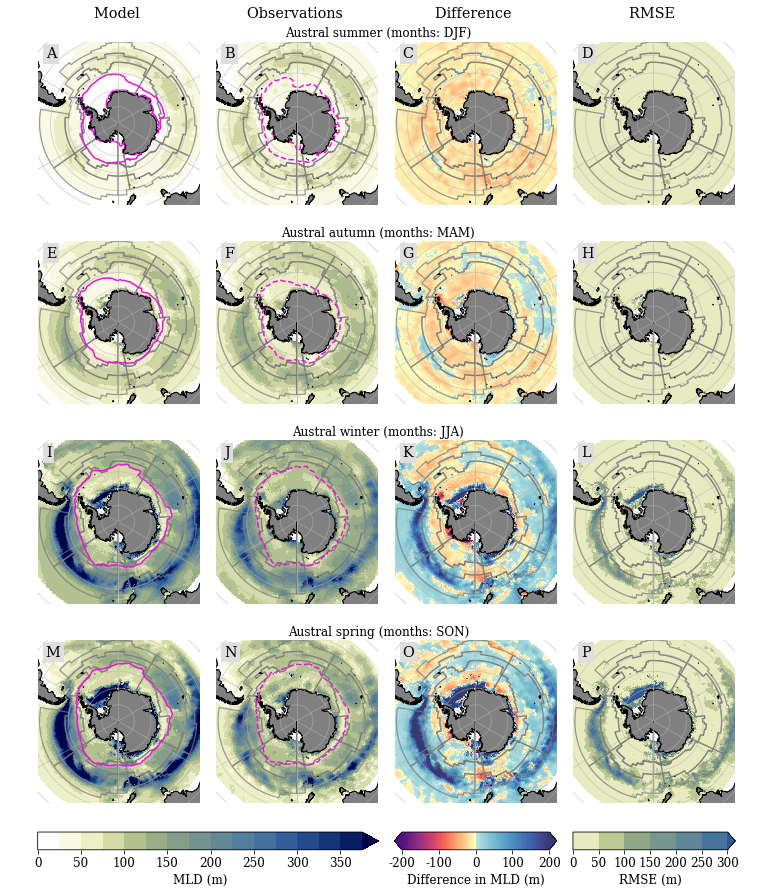

In [202]:
#Ensure folder where figures will be saved exists
folder_out = varDict['clim_fig']
os.makedirs(folder_out, exist_ok = True)

#Initialise figure
fig = plt.figure(figsize = (12.5, 15))

#######
###Colorbar settings
#Levels for colorbar
clim_levels = np.arange(0, 400, 25)
diff_levels = np.arange(-100, 100, 25)
contour_levels = np.concatenate((np.arange(-1500., -199, 500), 
                                 np.arange(-100, 101, 50),
                                 np.arange(300, 2000, 500)))

#Get a colormap from Scientific Colour Maps for absolute MLD values
cmap, cmap_r = zsf.colourMaps('../../ScientificColourMaps6/', 'davos', rev = True)

#Colormap for RMSE values
cmap_rmse = mcolors.LinearSegmentedColormap.from_list('my_colormap', cmap_r(np.linspace(0.15, 0.75, 128)))

#Create colormap for differences
#Ensure colormap diverges at zero regardless of max and min values
divnorm = mcolors.TwoSlopeNorm(vmin = -200, vcenter = 0, vmax = 200)
#Create new diverging colormap from existing colormaps to make it
#easy to distinguish positive and negative values
colors1 = plt.cm.magma(np.linspace(0.25, 1, 128))
colors2 = cm.cm.ice_r(np.linspace(0.1, 0.75, 128))
colors = np.vstack((colors1, colors2))
mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)
#Set NA values to show as white
mymap.set_bad('white')
#######

#Set font family and font size for the entire graph
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12

#Define projection to polar
projection = ccrs.SouthPolarStereo()

#Create variable containing the Antarctic continent - 50m is medium scale
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'black',
                                   facecolor = 'gray', linewidth = 0.5)

#Creating counter for plotting loop
#Defining season names
seasonName = {'Summer': 'Austral summer (months: DJF)', 
              'Autumn': 'Austral autumn (months: MAM)', 
              'Winter': 'Austral winter (months: JJA)', 
              'Spring': 'Austral spring (months: SON)'}
#Defining datasets to be plotted
data = ['Model', 
        'Observations', 
        'Difference',
        'RMSE']
#Merge seasons and datasets
counter = zip(cycle(data), np.repeat(list(seasonName), len(data)))

########
#Create composite figure using a grid
gs = gridspec.GridSpec(nrows = len(seasonName)+1, ncols = len(data),
                       height_ratios = (1, 1, 1, 1, 0.1))
#Change the width between each plot
gs.update(wspace = 0.1, hspace = 0.15)

#Initiliase dictionary to store axes
ax = {}

#Creating plot using loops
for i, coord in enumerate(counter):   
    ax[i] = fig.add_subplot(gs[i], projection = projection)
    if coord[0] == 'Model':
        p1 = seasons_SO[coord[1]].mean('time').\
        plot.pcolormesh(x = 'lon', y = 'lat', ax = ax[i],
                                  cmap = cmap_r, levels = clim_levels,
                                  transform = ccrs.PlateCarree(), add_colorbar = False)
        SIC_mod.sel(season = coord[1]).plot.contour(x = 'xt_ocean', y = 'yt_ocean', 
                                                    ax = ax[i], levels = [0.15],
                                                    transform = ccrs.PlateCarree(),
                                                    colors = '#ea11e3',
                                                    add_colorbar = False)
    elif coord[0] == 'Observations':
        p1 = seasonal_clim_obs[coord[1]].mean('time').plot.pcolormesh(x = 'lon', y = 'lat', ax = ax[i],
                                  cmap = cmap_r, levels = clim_levels,
                                  transform = ccrs.PlateCarree(), add_colorbar = False)
        SIC_obs[coord[1]].plot.contour(levels = [.15], ax = ax[i], 
                                       colors = '#ea11e3',
                                       linestyles = 'dashed')
    elif coord[0] == 'Difference':
        p2 = clim_dif[coord[1]].plot.pcolormesh(x = 'lon', y = 'lat', ax = ax[i],
                                                cmap = mymap, norm = divnorm, 
                                                transform = ccrs.PlateCarree(), 
                                                add_colorbar = False)
    else:
        p3 = rmse[coord[1]].plot.pcolormesh(x = 'lon', y = 'lat', ax = ax[i],
                                                cmap = cmap_rmse, levels = np.arange(0, 301, 50),
                                                transform = ccrs.PlateCarree(), 
                                                add_colorbar = False)
        
    #Add MEASO limits
    MEASO.plot(color = 'none', lw = 1.25, ax = ax[i], edgecolor = '#7b7b7b',
              alpha = 0.75)
    
    #Set title for each map
    if i < 4:
        ax[i].set_title(f'{coord[0]} \n', y = 1.01)
    else:
        ax[i].set_title(f'', y = 1.01)
    
    if i in [2, 6, 10, 14]:
        ax[i].text(-0.10, 1.05, f'{seasonName[coord[1]]}', horizontalalignment = 'center', verticalalignment = 'center', 
                   transform = ax[i].transAxes)

    #Remove x and y axes labels
    ax[i].set_ylabel("")
    ax[i].set_xlabel("")
      
    #Add land and coastlines
    ax[i].add_feature(land_50m)
    ax[i].coastlines(resolution = '50m')
    #Set extent shown
    ax[i].set_extent([-180, 180, -90, -42.5], crs = ccrs.PlateCarree())
    
    #Draw gridlines
    gl = ax[i].gridlines(draw_labels = True, y_inline = False, 
                              color = "#b4b4b4", alpha = 0.6)
    #Removing coordinate labels for latitude and longitude
    gl.xlabel_style = {'alpha': 0}
    gl.ylabel_style = {'alpha': 0}
    #Remove the outside frame and ticklines of the figure
    [s.set_visible(False) for s in ax[i].spines.values()]
    [t.set_visible(False) for t in ax[i].get_xticklines()]
    [t.set_visible(False) for t in ax[i].get_yticklines()]

ax_col = fig.add_subplot(gs[-1, 0:2])
cb = plt.colorbar(p1, cax = ax_col, orientation = 'horizontal', 
                  extend = 'max', shrink = 0.5,
                  label = varDict['short_name'] + ' (' + varDict['unit'] + ')')

ax_dif = fig.add_subplot(gs[-1, 2])
cb_dif = plt.colorbar(p2, cax = ax_dif, orientation = 'horizontal', 
                  extend = 'both', shrink = 0.5,
                  label = 'Difference in MLD (' + varDict['unit'] + ')')

cb_dif.set_ticks([-200, -100, 0, 100, 200])
cb_dif.set_ticklabels([-200, -100, 0, 100, 200])

ax_rmse = fig.add_subplot(gs[-1, 3])
cb_rmse = plt.colorbar(p3, cax = ax_rmse, orientation = 'horizontal', 
                  extend = 'max', shrink = 0.5, label = 'RMSE (' + varDict['unit'] + ')')

#Labelling plots
#Getting the alphabet in upper case
labels = string.ascii_uppercase[0:16]
#Apply labels only to plots, not colorbars
for a in ax:
    if a < 16:
        ax[a].text(0.05, .9, labels[a], transform = ax[a].transAxes, 
                   fontsize = 'large',
                   bbox = dict(facecolor = '#dedede', edgecolor = 'none',
                               pad = 3.0))

#Creating name to save this figure in local disk
fn = 'AllSeasonsClim_Comp_Mod-Obs_RMSE_' + varDict['short_name'] + '_1970-2018.png'

#Saving figure
plt.savefig(os.path.join(folder_out, fn), dpi = 300, bbox_inches = 'tight', 
            pad_inches = 0.05)

# Calculating linear trends in mixed layer depth for model data
First, we need to split the model outputs into seasons for the period between 1970 and 2018.

In [16]:
#Splitting model data into months to classify data into seasons
mod_SO = SO.sel(time = slice('1970-01', '2018-12')).groupby('time.month')

#Starting an empty list to store results
seasons_SO_gn = {}

#Loop through seasons
for season in seasonNames.keys():
    #Empty variable to store seasonal results
    da_sea = []
    #Match months in dataset with seasons as defined in 7.3.1.
    for m, da in mod_SO:
        if m in seasonNames[season]:
            da_sea.append(da)
    seasons_SO_gn[season] = xr.concat(da_sea, dim = 'time').sortby('time')

Now we can calculate the seasonal trends per pixel.

In [11]:
#Folder where linear trends will be saved
dir_out = varDict['linear_trends']
#Ensure directory exists prior to saving results
os.makedirs(dir_out, exist_ok = True)

#Calculating linear trend for each season
for season in seasonName:
    #Define file name
    fn = f'LinearTrend_MLD_{season}_1970-2018.nc'

    #Extracting years to calculate linear trends
    time_ind = np.arange(0, len(seasons_SO_gn[season].time))
    #Extract values from SIC data and create a vector
    vals = seasons_SO_gn[season].values.reshape(len(time_ind), -1)

    #Save coefficients and pvalues for linear regression calculations
    slope, intercept, r, p, se = np.apply_along_axis(zsf.lm_yr, 0, vals, x = time_ind)

    #Reshaping coefficients and pvalues to original dimensions of the data array
    coef_r = xr.DataArray(data = slope.reshape(seasons_SO_gn[season][0].shape), 
                          dims = ["yt_ocean", "xt_ocean"], 
                          coords = dict(xt_ocean = seasons_SO_gn[season].xt_ocean.values, 
                                        yt_ocean = seasons_SO_gn[season].yt_ocean.values),
                          name = "coefficients")

    pval_r = xr.DataArray(data = p.reshape(seasons_SO_gn[season][0].shape), 
                          dims = ["yt_ocean", "xt_ocean"], 
                          coords = dict(xt_ocean = seasons_SO_gn[season].xt_ocean.values, 
                                        yt_ocean = seasons_SO_gn[season].yt_ocean.values),
                          name = "p_values")
    
    std_err = xr.DataArray(data = se.reshape(seasons_SO_gn[season][0].shape), 
                      dims = ["yt_ocean", "xt_ocean"], 
                      coords = dict(xt_ocean = seasons_SO_gn[season].xt_ocean.values, 
                                    yt_ocean = seasons_SO_gn[season].yt_ocean.values),
                      name = "std_err")

    LM_results = xr.merge([coef_r, pval_r, std_err])

    #Saving outputs
    LM_results.to_netcdf(os.path.join(dir_out, fn))

## Loading linear trends to avoid recalculating

In [35]:
#Getting a list with the full file path of files that need to be loaded
filelist = glob(os.path.join(varDict['linear_trends'], '*1970*.nc'))

#Initialising empty dictionary to store results
LM_results = {}

#Load data - One entry per season
for season in seasonNames:
    file = [file for file in filelist if season in file]
    LM_results[season] = xr.open_dataset(file[0])

## Plotting seasonal linear trends from model data - Figure 7 in publication

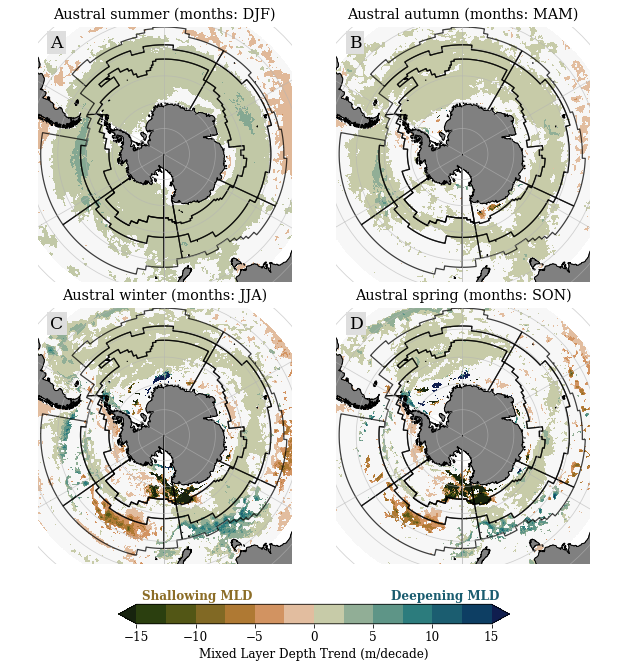

In [44]:
#Ensure folder where figures will be saved exists
folder_out = varDict['lm_fig']
os.makedirs(folder_out, exist_ok = True)

#Initialise figure
fig = plt.figure(figsize = (10, 12.5))

#Set labels for plotting
levels = np.arange(-15, 16, 2.5)

#Create colormap for differences
#Ensure colormap diverges at zero regardless of max and min values
divnorm = mcolors.TwoSlopeNorm(vmin = -15, vcenter = 0, vmax = 15)
#Create new diverging colormap from existing colormaps to make it
#easy to distinguish positive and negative values
colors1 = cm.cm.tarn(np.linspace(0, 0.425, 128))
colors2 = cm.cm.tarn(np.linspace(0.575, 1, 128))
colors = np.vstack((colors1, colors2))
mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)
#Set NA values to show as white
mymap.set_bad('white')
#######

#Set font family and font size for the entire graph
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12

#Defining season names
seasonName = {'Summer': 'Austral summer (months: DJF)', 
              'Autumn': 'Austral autumn (months: MAM)', 
              'Winter': 'Austral winter (months: JJA)', 
              'Spring': 'Austral spring (months: SON)'}

#Define projection to polar
projection = ccrs.SouthPolarStereo()

#Create variable containing the Antarctic continent - 50m is medium scale
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'black', 
                                   facecolor = 'gray', 
                                   linewidth = 0.5)

########
#Create composite figure using a grid
gs = gridspec.GridSpec(nrows = 2, ncols = 2)
#Change the width between each plot
gs.update(wspace = 0.15, hspace = 0.1)

ax = {}

#Getting the alphabet in upper case to label plots
labels = string.ascii_uppercase[0:4]

#Create counter using a list: i and j define the plot, while season refers to season
for i, j, season in [(0, 0, 'Summer'), (0, 1, 'Autumn'), 
                     (1, 0, 'Winter'), (1, 1, 'Spring')]:
    ax[season] = fig.add_subplot(gs[i, j], projection = projection)
    #Extract information for each season and start plotting
    data = LM_results[season].coefficients
    #Standard errors
    se = LM_results[season].std_err
    
    #Create mask to cover non-significant trends (i.e., absolute trends less than std error
    #of trend)
    mask = xr.where(np.fabs(data) < se, 1, np.nan) 
    
    ###Plotting
    #Multiplying trends by -10 to get change in meters per decade
    p1 = (data*10).plot.pcolormesh(ax = ax[season], cmap = mymap,
                              transform = ccrs.PlateCarree(), 
                              # vmin = -15, vmax = 15, 
                                   levels = levels, add_colorbar = False)
    #Apply mask
    mask.plot.contourf(colors = '#f7f7f7', ax = ax[season],
                       transform = ccrs.PlateCarree(), 
                       add_colorbar = False)
    
    #Add MEASO limits
    MEASO.plot(color = 'none', lw = 1.25, ax = ax[season], edgecolor = 'black',
              alpha = 0.75)
    
    #Set title for each subplot.
    ax[season].set_title(seasonName[season], y = 1.01)
    #Remove x and y axes labels
    ax[season].set_ylabel("")
    ax[season].set_xlabel("")
      
    #Add land and coastlines
    ax[season].add_feature(land_50m)
    ax[season].coastlines(resolution = '50m')
    
    #Set map extent
    ax[season].set_extent([-180, 180, -90, -42.5], crs = ccrs.PlateCarree())

    #Draw gridlines
    gl = ax[season].gridlines(draw_labels = True, y_inline = False, 
                              color = "#b4b4b4", alpha = 0.6)
    #Removing latitude and longitude labels
    gl.xlabel_style = {'alpha': 0}
    gl.ylabel_style = {'alpha': 0}
    #Remove the outside frame and ticklines of the figure
    [s.set_visible(False) for s in ax[season].spines.values()]
    [t.set_visible(False) for t in ax[season].get_xticklines()]
    [t.set_visible(False) for t in ax[season].get_yticklines()]

#Colorbar settings
cb = fig.colorbar(p1, ax = [ax[a] for a in ax],
                  orientation = 'horizontal', 
                  shrink = 0.7, pad = 0.06, 
                  label = 'Mixed Layer Depth Trend (m/decade)')

#Add labels to improve readability
#Get colormap to extract colors for labels
cmap = mcm.get_cmap(mymap)
cb.ax.text(6.5, 1.25, 'Deepening MLD', color = cmap(0.85), fontweight = 'bold')
cb.ax.text(-14.5, 1.25, 'Shallowing MLD', color = cmap(0.25), fontweight = 'bold')

#Apply labels only to plots, not colorbars
for i, a in enumerate(ax):
    ax[a].text(0.05, .92, labels[i], transform = ax[a].transAxes, 
               fontsize = 'x-large',
               bbox = dict(facecolor = '#dedede', edgecolor = 'none',
                               pad = 3.0))

#Name to save figure
fn = 'SeasonalLinearTrends_MLD_1970-2018.png'

#Saving figure to local directory
plt.savefig(os.path.join(folder_out, fn), dpi = 300, bbox_inches = 'tight', 
            pad_inches = 0.05)

# Calculating summary statistics per season and MEASO region - Table A.1
We will split the data into MEASO regions and calculate median values and the interquantile range for model data. RMSE values will be calculated using observations.

## Loading MEASO sectors mask
We will use the MEASO mask that matches the MLD observations grid.

In [75]:
#Loading mask
regions = xr.load_dataarray('../SupportingData/Masks/MEASO_MLD-obs_3Dmask.nc')

#Defining sector names in order
sectorNames = regions.region.values

#Subsetting shapefiles into regions - Initialise dictionary that will contain sector limits
MEASOregions = {}

#Saving each sector as an entry in the dictionary
for sec in sectorNames:
    MEASOregions[sec] = regions.sel(region = sec)
    
MEASOregions.keys()

dict_keys(['West Pacific Antarctic', 'West Pacific Subantarctic', 'West Pacific Northern', 'Atlantic Antarctic', 'Atlantic Northern', 'Atlantic Subantarctic', 'Central Indian Antarctic', 'Central Indian Northern', 'Central Indian Subantarctic', 'East Indian Antarctic', 'East Indian Northern', 'East Indian Subantarctic', 'East Pacific Antarctic', 'East Pacific Northern', 'East Pacific Subantarctic'])

## Splitting seasonal data (obs and regridded model) into MEASO sectors

In [74]:
#Ensuring output folder exists
out_folder = varDict['clipped_data']
#Ensuring file exists
os.makedirs(out_folder, exist_ok = True)

#Subsetting shapefiles into sectors - Initialise dictionary that will contain sector limits
clipped_MLD = {}
clipped_MLD_obs = {}

#Looping through seasons and MEASO sectors
for season in seasonNames:
    for sector in sectorNames:
        clipped_MLD[f'{sector}_{season}'] = seasons_SO[season]*MEASOregions[sector]
        clipped_MLD_obs[f'{sector}_{season}'] = seasonal_clim_obs[season]*MEASOregions[sector]    
        #Creating names to save clipped data
        fn_mod = f'MLD_{season}_{sector}_model_reg_1970-2018.nc'
        fn_obs = f'MLD_{season}_{sector}_obs_1970-2018.nc'
        #Saving outputs
        clipped_MLD[f'{sector}_{season}'].to_netcdf(os.path.join(out_folder, fn_mod))
        clipped_MLD_obs[f'{sector}_{season}'].to_netcdf(os.path.join(out_folder, fn_obs))

### Loading clipped data to avoid recalculation

In [12]:
#Getting files previously splitted into seasons and sectors
files_mod = glob(os.path.join(varDict['clipped_data'], '*model_reg*.nc'))
files_obs = glob(os.path.join(varDict['clipped_data'], '*obs*.nc'))

#Create empty list to save clipped data 
clipped_MLD = {}
clipped_MLD_obs = {}

#Looping through seasons and MEASO sectors
for season in seasonNames:
    mod_sea_f = [f for f in files_mod if season in f]
    obs_sea_f = [f for f in files_obs if season in f]
    for sector in sectorNames:
        clipped_MLD[f'{sector}_{season}'] = xr.open_dataarray([f for f in mod_sea_f if sector in f][0])
        clipped_MLD_obs[f'{sector}_{season}'] = xr.open_dataarray([f for f in obs_sea_f if sector in f][0])

## Splitting seasonal model (native grid) data into MEASO sectors

# Loading MEASO sectors mask
We will use the MEASO mask that matches the ACCESS-OM2-01 grid.

In [47]:
#Loading mask
regions = xr.load_dataarray('../SupportingData/Masks/MEASO_ACCESS_3Dmask.nc')

#Defining sector names in order
sectorNames = regions.region.values

#Subsetting shapefiles into regions - Initialise dictionary that will contain sector limits
MEASOregions = {}

#Saving each sector as an entry in the dictionary
for sec in sectorNames:
    MEASOregions[sec] = regions.sel(region = sec)
    
MEASOregions.keys()

dict_keys(['West Pacific Antarctic', 'West Pacific Subantarctic', 'West Pacific Northern', 'Atlantic Antarctic', 'Atlantic Northern', 'Atlantic Subantarctic', 'Central Indian Antarctic', 'Central Indian Northern', 'Central Indian Subantarctic', 'East Indian Antarctic', 'East Indian Northern', 'East Indian Subantarctic', 'East Pacific Antarctic', 'East Pacific Northern', 'East Pacific Subantarctic'])

In [62]:
clim_ng = SO.sel(time = slice('1970-01', '2018-12'))

#Starting an empty list to store results
seasons_SO_ng = {}

#Calculating seasonal climatological mean per season
for season in seasonNames.keys():
    y = []
    for i, m in enumerate(clim_ng.time.dt.month.values.tolist()):
        if m in seasonNames[season]:
            y.append(clim_ng[i])
    seasons_SO_ng[season] = xr.concat(y, dim = 'time')

## Calculating statistics for each sector and season combination

In [66]:
#Subsetting shapefiles into sectors - Initialise dictionary that will contain sector limits
mld_stats = []

#Saving each sector as an entry in the dictionary
for sea in seasons_SO_ng:
    #Selecting season
    sea_MLD = seasons_SO_ng[sea].mean('time')
    #Applying sector mask
    for sec in sectorNames:
        clip_sea_MLD = sea_MLD*MEASOregions[sec]
        #Calculate quantiles and save in list 
        mld_stats.append(clip_sea_MLD.quantile([.25, .5, .75]).\
        expand_dims({'region': [sec], 'season': [sea]}))

#Create data array from list
mld_stats = xr.combine_by_coords(mld_stats)

## Rearranging statistics for easy export

In [ ]:
mld_statspd = []
for i, sea in enumerate(seasons_SO_ng):
    x = mld_stats.sel(season = sea).to_pandas()
    x['season'] = sea
    mld_statspd.append(x)

mld_statspd = pd.concat(mld_statspd)
mld_statspd

In [78]:
#Creating empty pandas dataframe to store results
error = pd.DataFrame({'rmse':[], 'key': []})

#Looping through each sector/season combination to calculate stats
for i, key in enumerate(clipped_MLD):
    vals = []
    #RMSE calculation
    rmse = np.sqrt((clipped_MLD[key]-clipped_MLD_obs[key])**2).mean().values.tolist()
    #Merging results together
    vals.append(rmse)
    #Adding the sector/season
    vals.append(key)
    error.loc[i] = vals
    
#Checking results
error

,rmse,key
0,18.981384,West Pacific Antarctic_Summer
1,20.233641,West Pacific Subantarctic_Summer
2,14.833932,West Pacific Northern_Summer
3,17.934435,Atlantic Antarctic_Summer
4,12.135987,Atlantic Northern_Summer
5,12.429765,Atlantic Subantarctic_Summer
6,13.746519,Central Indian Antarctic_Summer
7,11.100261,Central Indian Northern_Summer
8,12.512416,Central Indian Subantarctic_Summer
9,11.991979,East Indian Antarctic_Summer


In [91]:
error.to_clipboard

<bound method NDFrame.to_clipboard of           rmse                                 key
0    18.981384       West Pacific Antarctic_Summer
1    20.233641    West Pacific Subantarctic_Summer
2    14.833932        West Pacific Northern_Summer
3    17.934435           Atlantic Antarctic_Summer
4    12.135987            Atlantic Northern_Summer
5    12.429765        Atlantic Subantarctic_Summer
6    13.746519     Central Indian Antarctic_Summer
7    11.100261      Central Indian Northern_Summer
8    12.512416  Central Indian Subantarctic_Summer
9    11.991979        East Indian Antarctic_Summer
10   22.411772         East Indian Northern_Summer
11   22.368863     East Indian Subantarctic_Summer
12   15.571341       East Pacific Antarctic_Summer
13   14.177856        East Pacific Northern_Summer
14   22.210518    East Pacific Subantarctic_Summer
15   25.017486       West Pacific Antarctic_Autumn
16   18.972193    West Pacific Subantarctic_Autumn
17   13.729110        West Pacific Northern_